In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy import interpolate, optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import helper
import os
from matplotlib.lines import Line2D

In [2]:
fit_results_path = '../model_fit_results'
exp_measures = pd.read_csv('../data/measures.csv')

# Model diagram

In [3]:
'''Parameter values:  
drift=DriftTtaDistance(
    alpha=Fitted(0.981751568572023, minval=0.1, maxval=3), 
    tta_crit=Fitted(4.540489436924537, minval=3, maxval=6),  
    beta=Fitted(0.044790083741267264, minval=0, maxval=1), 
    d_crit=Fitted(126.47533311922697, minval=90, maxval=150)), 
noise=NoiseConstant(noise=1), 
bound=BoundCollapsingTta(
    b_0=Fitted(1.194837718254345, minval=0.5, maxval=5),
    k=Fitted(0.2613552424813064, minval=0.1, maxval=2), 
    tta_crit=Fitted(4.540489436924537, minval=3, maxval=6)), 
overlay=OverlayNonDecisionUniform(
    nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), 
    halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3))
'''

alpha = 0.98
tta_crit = 4.54
beta = 0.04479
d_crit = 126.6
b_0 = 1.2
k = 0.26
nd_time_mean = 0.328
nd_halfwidth = 0.227

def get_trace():   
    noise = np.random.randn(len(t))
    drift = alpha*(tta-tta_crit+beta*(d-d_crit))
    dx = drift * dt + noise * np.sqrt(dt)
    x = np.append([0], np.cumsum(dx)[:-1])
    nd_time_idx = int(np.random.uniform(nd_time_mean-nd_halfwidth, nd_time_mean+nd_halfwidth) // dt)
    nd_time = t[nd_time_idx]
    
    return x

In [ ]:
is_two_correct = False
while not is_two_correct:
    trials = [get_trace() for i in range(3)]
    is_two_correct = (np.sum([1 if x[-1]>0 else 0 for x in trials]) == 2)
pd.DataFrame(trials).to_csv('ddm_traces.csv')

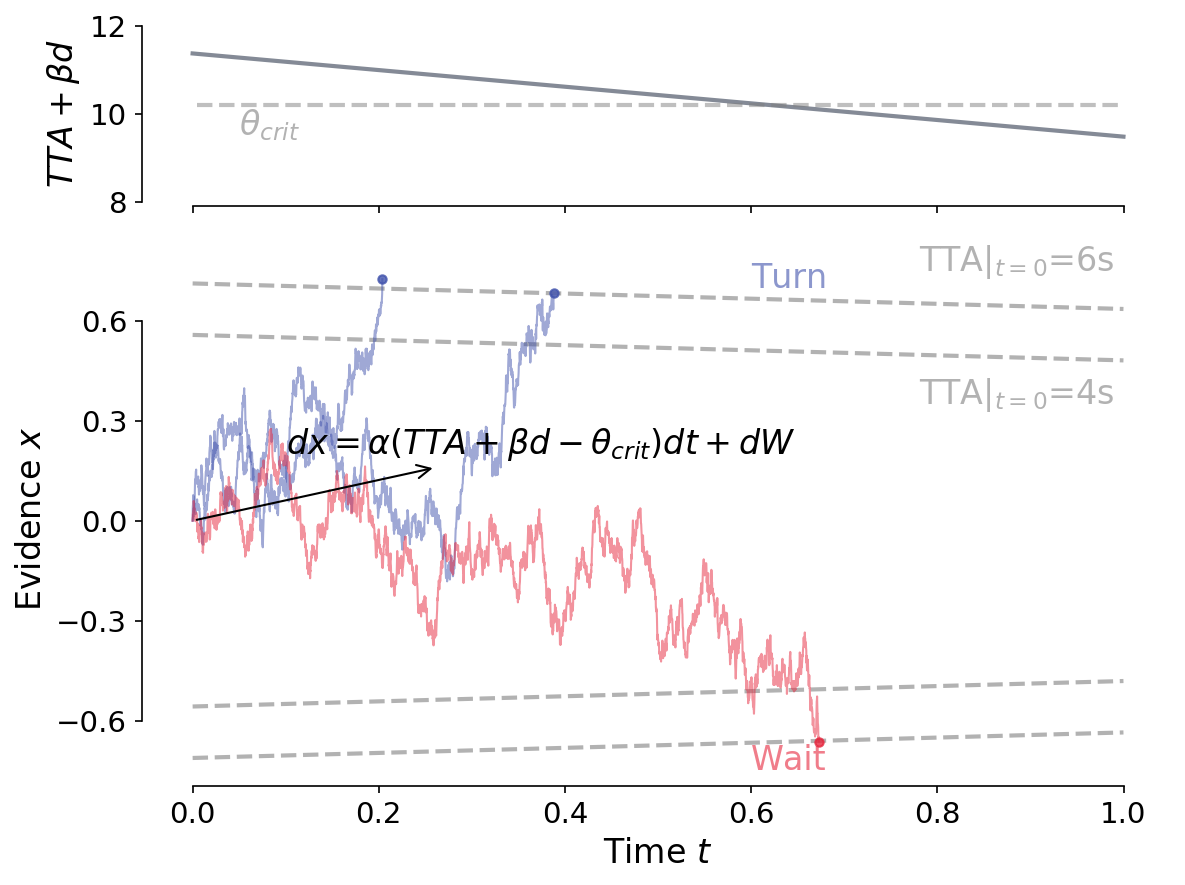

In [4]:
# def add_inset(ax):
#     ax_ins = inset_axes(ax, width=1.3, height=0.9, loc='center right')
#     tau_ins = np.linspace(0, 10)
#     f = 1/(1+np.exp(-k*(tau_ins-tta_crit)))
#     f_approx = 0.5 + 0.05*(tau_ins-tta_crit)

#     ax_ins.plot(tau_ins, f)
#     ax_ins.plot(tau_ins, f_approx)
#     ax_ins.axvline(tta_crit, color='grey', ls='--', lw=1)
#     ax_ins.set_xlabel(r'$\tau$', fontsize=8)
#     ax_ins.set_ylabel('boundary', fontsize=8)
#     ax_ins.set_title(r'$f(\tau) = b_0/(1+e^{-k(\tau-\tau_{crit})})$', fontsize=8)
#     ax_ins.text(x=tta_crit, y=0.3, s=r'$\tau_{crit}$', fontsize=8);
#     ax_ins.tick_params(axis='both', which='major', labelsize=8)

#     sns.despine(offset=5, trim=True)

tta_condition = 6
d_condition = 120

v_condition = d_condition / tta_condition
dt = 0.0001
t = np.arange(0, 1.0, dt)
d = d_condition - v_condition*t

fig, (ax_tau, ax) = plt.subplots(2, 1, figsize=(8,6), gridspec_kw={'height_ratios': [1, 3]}, dpi=150, sharex=True)

ax.annotate(r'$dx = \alpha(TTA + \beta d - \theta_{crit}) dt + dW$', xy=(0,0), xytext=(0.1, 0.2),
             arrowprops=dict(arrowstyle='<-', connectionstyle='arc3'), fontsize=16)

ax.text(0.6, 0.7, 'Turn', color='#4052ac', alpha=0.6, fontsize=16)
ax.text(0.6, -0.75, 'Wait', color='#e6263d', alpha=0.6, fontsize=16)
ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])

for tta_condition in [4, 6]:
    tta = tta_condition - t
    boundary = b_0/(1+np.exp(-k*(tta-tta_crit)))
    ax.plot(t, boundary, ls='--', color='gray', alpha=0.6)
    ax.plot(t, -boundary, ls='--', color='gray', alpha=0.6)
    ax.text(0.78, 0.35+0.2*(tta_condition-4), r'TTA$|_{t=0}$=%is' % (tta_condition), color='grey', alpha=0.6, fontsize=16)

trials = [x[1].values[1:] for x in pd.read_csv('ddm_traces.csv').iterrows()]
    
for x in trials:
    response_time_idx = np.where(abs(x)>boundary)[0][0]
    response_time = t[response_time_idx]
    ax.plot(t[t<=response_time][::2], x[t<=response_time][::2], lw=1.0, alpha=0.5, 
            color='#4052ac' if x[response_time_idx]>0 else '#e6263d')
    ax.plot(t[t==response_time], x[t==response_time], ls='', alpha=0.8, marker='o', ms=4,
            color='#4052ac' if x[response_time_idx]>0 else '#e6263d')
    ax.set_xlabel(r'Time $t$', fontsize=16)
    ax.set_ylabel(r'Evidence $x$', fontsize=16)

ax_tau.plot(t, tta+beta*d, color='#50596A', alpha=0.7)
ax_tau.axhline(tta_crit+beta*d_crit, color='grey', alpha=0.5, ls='--', xmin=0.05, xmax=0.95)
ax_tau.set_ylabel(r'$TTA + \beta d$', fontsize=16)
ax_tau.set_ylim((8,12))
ax_tau.text(0.05, 9.5, r'$\theta_{crit}$', color='grey', alpha=0.6, fontsize=16)

sns.despine(offset=2, trim=True)
plt.tight_layout()
plt.savefig('../output/fig_model_diagram.png', bbox_inches='tight')

# Trial timeline

In [12]:
exp_data = pd.read_csv('../data/processed_data.csv', index_col=['subj_id', 'session', 'route', 'intersection_no'])
traj_id = (129, 1, 2, 5)
traj = exp_data.loc[traj_id]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


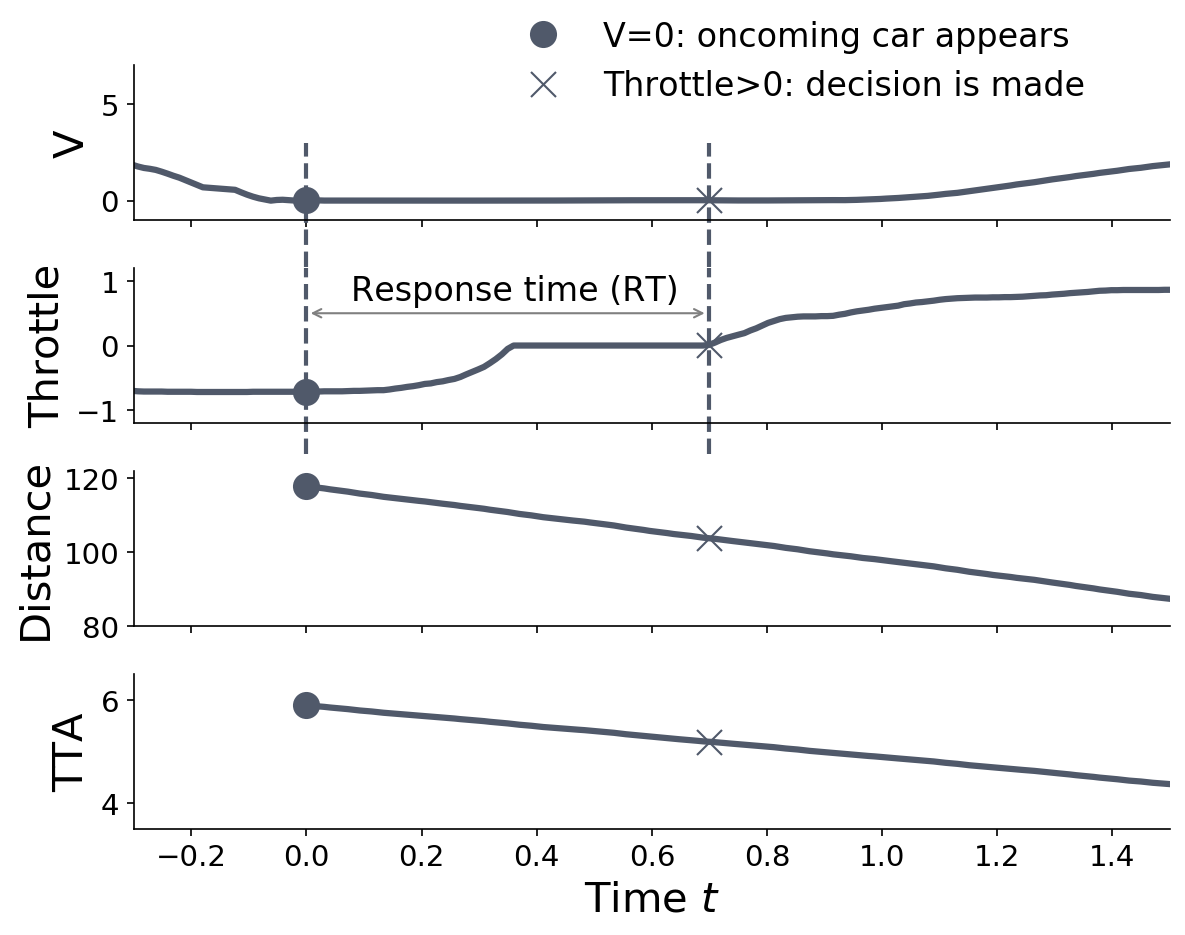

In [13]:
def plot_traj(traj):
    color='#50596A'
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    traj.loc[:, 't'] -= traj.t.values[idx_bot_spawn]
    
    fig, axes = plt.subplots(4, 1, figsize=(8,6), dpi=150, sharex=True)
    ms = 12
    lw=3
    axes[0].plot(traj.t, traj.ego_v, color=color, lw=lw)
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[0].set_ylabel('V')
    axes[0].set_ylim((-1, 7))
    
    for x in [traj.t[idx_bot_spawn], traj.t[idx_response]]:
        axes[0].axvline(x=x, ymin=-0.3, ymax=0.5, c=color, ls='--', clip_on=False)
        axes[1].axvline(x=x, ymin=-0.2, ymax=1, c=color, ls='--', clip_on=False)
    
    axes[1].annotate(s='', xy=(traj.t[idx_bot_spawn], 0.5), xytext=(traj.t[idx_response], 0.5), 
                     arrowprops=dict(arrowstyle='<->', color='0.5'))
    axes[1].text(.21, .79, 'Response time (RT)', transform=axes[1].transAxes, fontsize=16)
    
    throttle_brake = traj.throttle-traj.brake
    axes[1].plot(traj.t, throttle_brake, color=color, lw=lw)
    axes[1].plot(traj.t[idx_bot_spawn], throttle_brake[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[1].plot(traj.t[idx_response], throttle_brake[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[1].set_ylabel('Throttle')
    axes[1].set_ylim((-1.2, 1.2))

    axes[2].plot(traj.t[idx_bot_spawn:], traj.d_ego_bot[idx_bot_spawn:], color=color, lw=lw)
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color=color, ls='', marker='o', ms=ms)
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color=color, ls='', marker='x', ms=ms)
    axes[2].set_ylabel('Distance')
    axes[2].set_ylim((80, 122))

    axes[3].plot(traj.t[idx_bot_spawn:], traj.tta[idx_bot_spawn:], color=color, lw=lw)
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color=color, ls='', marker='o', 
                 label='V=0: oncoming car appears', ms=ms)
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color=color, ls='', marker='x', 
                 label='Throttle>0: decision is made', ms=ms)
    axes[3].set_ylabel('TTA')
    axes[3].set_ylim((3.5, 6.5))

    axes[3].set_xlim((-0.3, 1.5))
    
    axes[3].set_xlabel('Time $t$')

    legend = fig.legend(loc='upper left', bbox_to_anchor=(0.4, 1.05), frameon=False)
    legend.get_title().set_fontsize('18')
    plt.tight_layout()
    
plot_traj(traj)
plt.savefig('../output/fig_trial_timeline.png', bbox_inches='tight')

# Model fit against data

In [82]:
model_measures_all_conditions = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_all_measures.csv'))

In [6]:
def get_psf_ci(data):
    # psf is a psychometric function
    # ci is a dataframe with confidence intervals for probability per coherence
    tta_conditions = np.sort(data.tta_condition.unique())
    
    psf = np.array([len(data[(data.is_turn_decision) & (data.tta_condition==tta_condition)]) 
                                            / len(data[data.tta_condition==tta_condition]) 
                        if len(data[(data.tta_condition==tta_condition)]) > 0 else np.NaN 
                    for tta_condition in np.sort(data.tta_condition.unique())])

    ci = pd.DataFrame(psf, columns=['p_turn'], index=tta_conditions)

    n = [len(data[(data.tta_condition==tta_condition)]) for tta_condition in tta_conditions]

#     print(psf)
    ci['ci_l'] = ci['p_turn'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_turn'] + np.sqrt(psf*(1-psf)/n)

    return ci.reset_index().rename(columns={'index': 'tta_condition'})

def get_rt_mean_sem(data, n_cutoff=2):
    mean = data.groupby('tta_condition')['RT'].mean()
    sem = data.groupby('tta_condition')['RT'].apply(lambda x: scipy.stats.sem(x, axis=None, ddof=0))
    n = data.groupby('tta_condition').size()
    data_mean_sem = pd.DataFrame({'RT_mean': mean, 'RT_sem': sem, 'n': n}, index=mean.index)
    data_mean_sem = data_mean_sem[data_mean_sem.n>n_cutoff]
    return(data_mean_sem)

In [93]:
def plot_compare_model_exp(var, exp_data, model_measures, ylabel):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({'subj_id': str})

    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    markers=['o', 's', '^']
    colors = [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,len(d_conditions))]
    
    subjects = model_measures.subj_id.unique()
    
    fig, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

    for subj_id, ax in zip(subjects, axes.flatten()):
        ax.set_title('All participants' if subj_id=='all' else 'P%s' % (subj_id), fontsize=16)
        for d_condition, color, marker in zip(d_conditions, colors, markers):
            model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                                   & (model_measures.d_condition==d_condition)]
            
            if subj_id == 'all':
                data_subj_d_measures = exp_data[(exp_data.d_condition==d_condition)]
            else:
                data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]
            
            if var=='is_turn_decision':
                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], 
                    color=color, label=d_condition)
                psf_ci = get_psf_ci(data_subj_d_measures)            
                ax.plot(psf_ci.tta_condition, psf_ci.p_turn, ls='', marker=marker, ms=9, color=color, zorder=10)
                ax.vlines(x=psf_ci.tta_condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)
            elif var=='RT':
                data_subj_d_measures = data_subj_d_measures[data_subj_d_measures.is_turn_decision]
                if len(data_subj_d_measures)>0:
                    data_mean_sem = get_rt_mean_sem(data_subj_d_measures)
                    ax.errorbar(data_mean_sem.index, data_mean_sem.RT_mean, yerr=data_mean_sem.RT_sem, 
                                ls='', marker=marker, color=color)
                ax.plot(model_subj_d_measures.tta_condition, model_subj_d_measures[var], 
                    color=color, label=d_condition)

                ax.set_xticklabels([4, 5, 6])
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])
            else:
                raise(ValueError)

        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=9, lw=0, label='Data, d=%im' % (d_condition)) 
                       for d_condition, color, marker in zip(d_conditions, colors, markers)] 
                       + [Line2D([0], [0], color='grey', label='Model fits')])

    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(1.15, 0.55), fontsize=16, frameon=False)

    fig.text(0.4, -0.05, 'Time-to-arrival (TTA), s', fontsize=18)
    fig.text(-0.02, 0.3, ylabel, fontsize=18, rotation=90)

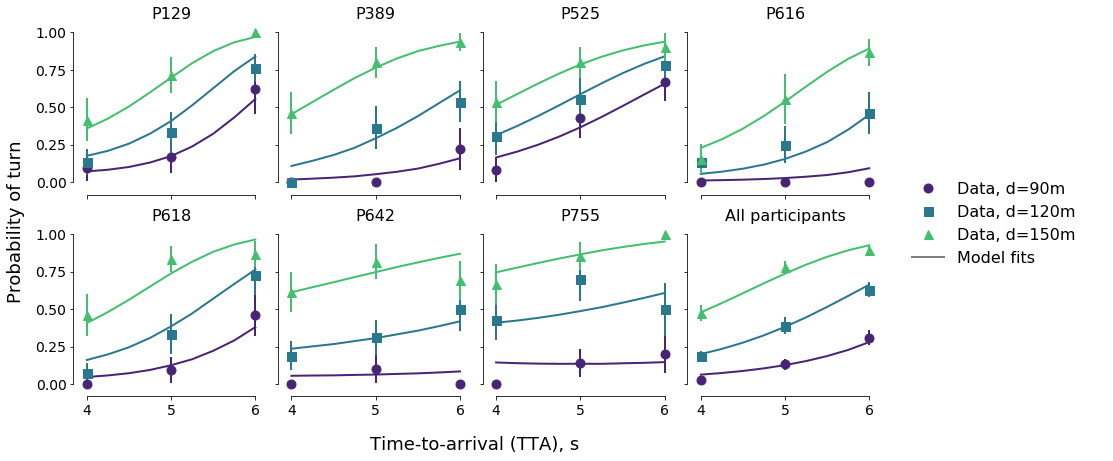

In [86]:
plot_compare_model_exp('is_turn_decision', exp_measures, model_measures_all_conditions, 'Probability of turn')
plt.savefig('../output/fig_p_turn.png', bbox_inches='tight')

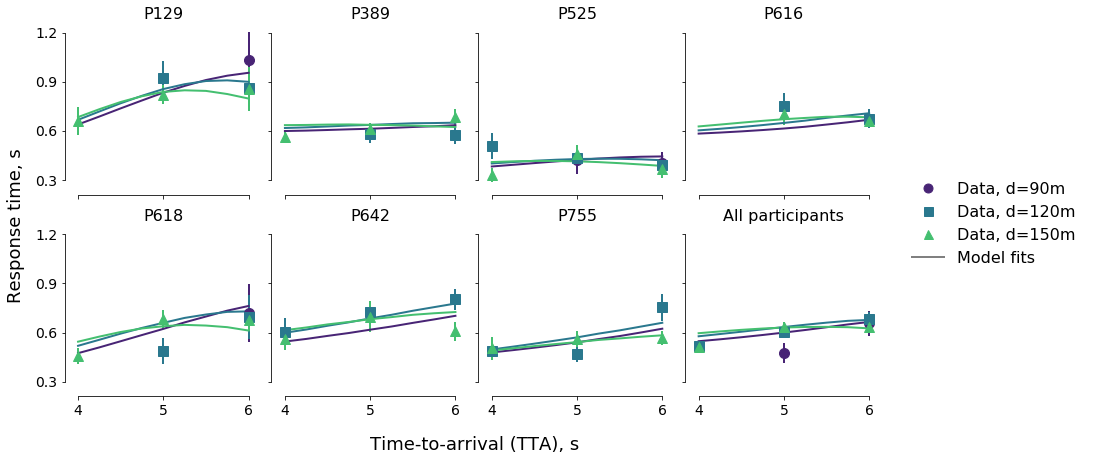

In [94]:
plot_compare_model_exp('RT', exp_measures, model_measures_all_conditions, 'Response time, s')
plt.savefig('../output/fig_RT.png', bbox_inches='tight')

# RT distributions

In [4]:
def plot_vincentized_rt_pdf(exp_data, model_rts, cumulative=False):
    fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)
    conditions = [{'d': d, 'TTA': TTA}
                  for d in sorted(exp_data.d_condition.unique()) 
                  for TTA in sorted(exp_data.tta_condition.unique())]
#     q = np.linspace(0.01, 0.99, 10)
    q = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    for (ax, condition) in zip(axes.flatten(), conditions):
        if (((condition['d'] == 90) & (condition['TTA'] == 6)) 
            | ((condition['d'] == 120) & (condition['TTA'] == 5)) 
            | ((condition['d'] == 150) & (condition['TTA'] == 4))):
            ax.text(0.5, 1.02, 'TTA=%is' % condition['TTA'], fontsize=18, transform=ax.transAxes, 
                        horizontalalignment='center', verticalalignment='center')

        if condition['TTA'] == 6:
            ax.text(1.0, 0.5, 'd=%im' % condition['d'], fontsize=18, transform=ax.transAxes, rotation=-90, 
                horizontalalignment='center', verticalalignment='center')
        
        condition_data = exp_data[(exp_data.is_turn_decision) 
                            & (exp_data.d_condition==condition['d']) 
                            & (exp_data.tta_condition==condition['TTA'])]
        if len(condition_data) >= 25:
            p_turn = (len(condition_data)
                      / len(exp_data[(exp_data.d_condition==condition['d']) & (exp_data.tta_condition==condition['TTA'])]))
#             ax.text(0.65, 0.2, 'n=%i' % (len(condition_data)), fontsize=12, transform=ax.transAxes,  
#                horizontalalignment='center', verticalalignment='center')
            
            condition_quantiles = condition_data.groupby('subj_id').apply(lambda d: np.quantile(a=d.RT, q=q)).mean()
            rt_range = np.linspace(condition_quantiles.min(), condition_quantiles.max(), len(q))
            step = rt_range[1] - rt_range[0]
            rt_grid = np.concatenate([rt_range[:3]-3*step, rt_range, rt_range[-3:]+step*3])
            vincentized_cdf = np.interp(rt_grid, condition_quantiles, q, left=0, right=1)
    
            if cumulative:
                ax.plot(rt_grid, vincentized_cdf, label='Data', color='C1', ls='', marker='o')
#                 ax.plot(condition_quantiles, q, label='Data', color='C1', ls='', marker='o')
                ax.set_ylim([-0.05, 1.1])
                ax.set_yticks([0.0, 0.5, 1.0])
            else:
                _, data_pdf = np.histogram(condition_data.RT, bins=rt_grid)
                vincentized_pdf = differentiate(t=rt_grid, x=vincentized_cdf)
                ax.plot(rt_grid, vincentized_pdf, label='Data', color='C1')
            
            if not model_rts is None:
                condition_rts = model_rts[(model_rts.subj_id=='all') 
                                        & (model_rts.d_condition==condition['d']) 
                                        & (model_rts.tta_condition==condition['TTA'])]
                ax.plot(condition_rts.t, condition_rts.rt_corr_pdf, label='Model', color='grey')
        else:
            ax.set_axis_off()
            
        ax.set_xlabel('')
        ax.set_xlim((0, 1.5))
        sns.despine(offset=5, trim=True)

    fig.text(0.4, 0.04, 'Response time', fontsize=18)
    fig.text(0.04, 0.2, 'CDF' if cumulative else 'PDF', fontsize=18, rotation=90)
    
    return fig, axes

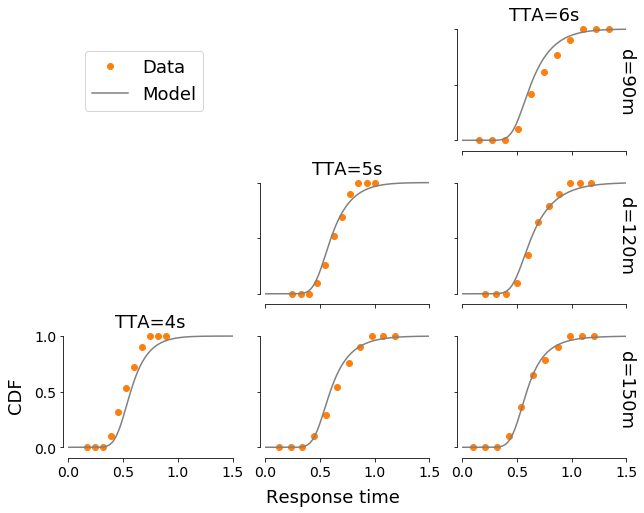

In [5]:
model_rts = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_all_rt_cdf.csv'))
fig, axes = plot_vincentized_rt_pdf(exp_measures, model_rts, cumulative=True)
fig.legend(labels=['Data', 'Model'], loc='center', bbox_to_anchor=(0.2, 0.75), fontsize=18, frameon=True)
plt.savefig('../output/fig_RT_dist.png', bbox_inches='tight')

# Model cross-validation

In [4]:
def plot_cross_validation(exp_data, model_measures):  
    #because of the bug in matplotlib/pandas, we need to convert subj_id to str to avoid warnings
    exp_data = exp_data.astype({'subj_id': str})

    model_measures = model_measures[(model_measures.tta_condition>=4.0) & (model_measures.tta_condition<=6.0)]

    d_conditions = [90, 120, 150]
    markers=['o', 's', '^']
    data_color='C1'
    model_color='grey'
    marker_size=10
    marker_offset = 0.1
    
    subjects = model_measures.subj_id.unique()
    subfigures = [(var, subj_id) for var in ['is_turn_decision', 'RT'] for subj_id in subjects]
    
    fig, axes = plt.subplots(2, 8, figsize=(16,6), sharex='col', sharey='row')

    for (var, subj_id), ax in zip(subfigures, axes.flatten()):
        if var=='is_turn_decision':
            ax.set_title('All participants' if subj_id=='all' else 'P%s' % (subj_id), fontsize=16)
        for d_condition, marker in zip(d_conditions, markers):
            model_subj_d_measures = model_measures[(model_measures.subj_id==subj_id) 
                                                   & (model_measures.d_condition==d_condition)]
            
            if subj_id == 'all':
                data_subj_d_measures = exp_data[(exp_data.d_condition==d_condition)]
            else:
                data_subj_d_measures = exp_data[(exp_data.subj_id==subj_id) & (exp_data.d_condition==d_condition)]
            
            if var=='is_turn_decision':
                ax.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures[var], 
                            color=model_color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size)
                psf_ci = get_psf_ci(data_subj_d_measures)            
                ax.plot(psf_ci.tta_condition-marker_offset, psf_ci.p_turn, ls='--', lw=1, marker=marker,
                        ms=marker_size, color=data_color, zorder=10)
                ax.vlines(x=psf_ci.tta_condition-marker_offset, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, 
                          color=data_color, alpha=0.6, zorder=10)
            elif var=='RT':
                ax.plot(model_subj_d_measures.tta_condition+marker_offset, model_subj_d_measures[var], 
                        color=model_color, label=d_condition, ls='--', lw=1, marker=marker, ms=marker_size)
                data_subj_d_measures = data_subj_d_measures[data_subj_d_measures.is_turn_decision]
                if len(data_subj_d_measures)>0:
                    data_mean_sem = get_rt_mean_sem(data_subj_d_measures)
                    ax.errorbar(data_mean_sem.index-marker_offset, data_mean_sem.RT_mean, yerr=data_mean_sem.RT_sem, 
                                ls='--', lw=1, marker=marker, color=data_color)
                ax.set_ylim((0.3, 1.2))
                ax.set_yticks([0.3, 0.6, 0.9, 1.2])

            else:
                raise(ValueError)

        ax.set_xticks([4, 5, 6])
        ax.legend().remove()
        ax.set_xlabel('')
        ax.set_ylabel('')
    sns.despine(offset=5, trim=True)
    plt.tight_layout()

    legend_elements = ([Line2D([0], [0], color=data_color, marker=marker, ms=marker_size, lw=0, label='Data, d=%im' % (d_condition)) 
                       for d_condition, marker in zip(d_conditions, markers)] 
                       + [Line2D([0], [0], color=model_color, marker='*', ms=marker_size, lw=0, label='Model predictions')])

    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.9, 1.2), fontsize=16, frameon=False)

    fig.text(0.4, -0.05, 'Time-to-arrival (TTA), s', fontsize=16)
    fig.text(-0.01, 0.55, 'Probability of turn', fontsize=16, rotation=90)
    fig.text(-0.01, 0.15, 'Response time', fontsize=16, rotation=90)

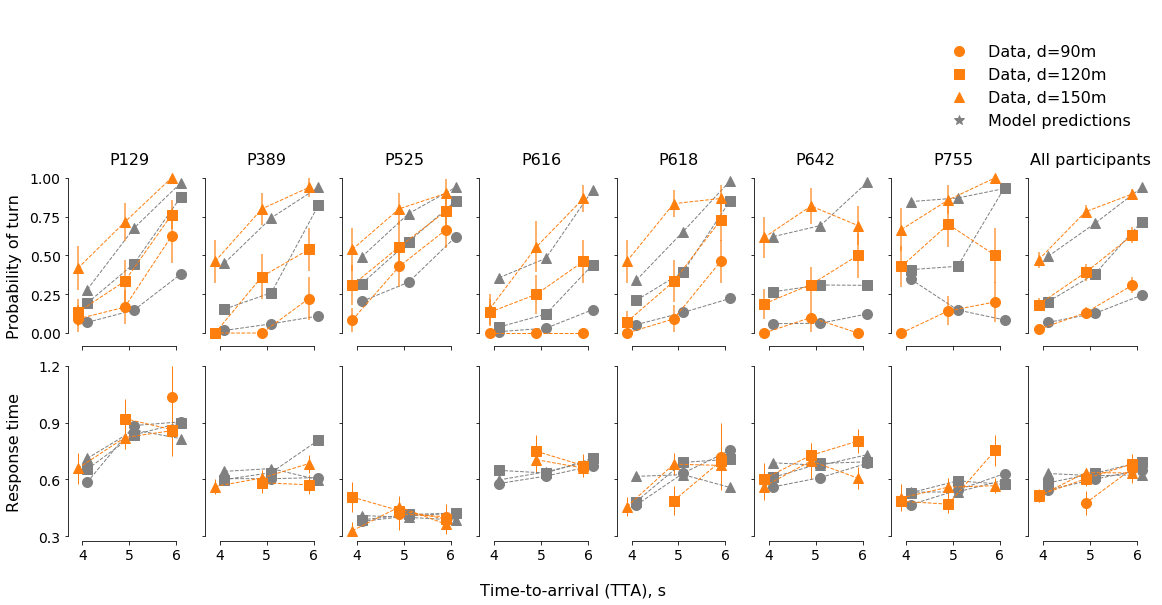

In [122]:
model_measures_cross_validation = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_8_measures.csv'))
plot_cross_validation(exp_measures, model_measures_cross_validation)
plt.savefig('../output/fig_cross_validation.png', bbox_inches='tight')

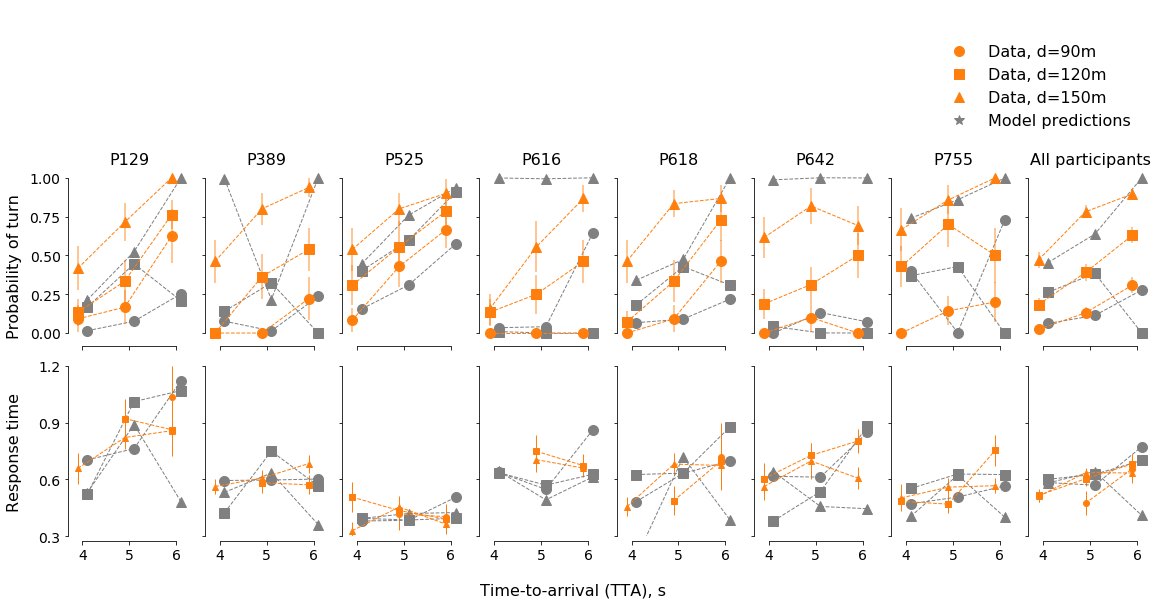

In [7]:
model_measures_cross_validation = pd.read_csv(os.path.join(fit_results_path, 'cross_validation_4_measures.csv'))
plot_cross_validation(exp_measures, model_measures_cross_validation)